In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
#from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from IPython import display


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor())) 

train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True,
                                             transform=train_transform,
                                             download=download)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=test_transform,
                                            )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [13]:
dataiter = iter(train_loader)
img, lab = dataiter.next() 
plt.imshow(img[1][0])
print(lab[1])

tensor(7)


torch.Size([128, 3, 32, 32])
128


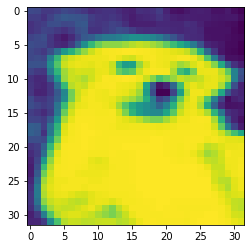

In [16]:
for img, label in train_loader:
    print(img.shape)
    plt.imshow(img[1][0])
    print(label.size(0))
    break

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self, image_size=32, num_classes=10):
        super(NeuralNetwork,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            )
        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            )
        
        self.fc=nn.Linear(32*(image_size//4)*(image_size//4),num_classes)
    def forward(self, x):

        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1)
        output=self.fc(x)
        return output

In [58]:
torchsummary.summary(NeuralNetwork().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 10]          20,490
Total params: 25,674
Trainable params: 25,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.61
Params size (MB): 0.10
Estimated Total Size (MB): 0.72
---------------------------------------------

In [59]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
#model = TinyNeuralNetwork().to(device)
model = NeuralNetwork()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
#optimizer = Adam(model.parameters(), lr=1e-3)
error = nn.CrossEntropyLoss() 
#error = nn.NLLLoss()

count = 0

loss_train_1 = []
loss_test_1 = []

accuracy_train_1 = []
accuracy_test_1 = []

for epoch in range(30):
    loss_train_epoch = []
    loss_test_epoch = []
    accuracy_train_epoch = []
    accuracy_test_epoch = []
    
    model.train(True)
    for i, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model(images)
            loss = error(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted1 = torch.max(outputs.data, 1)[1]
            total1 = len(labels)
            correct1 = (predicted1 == labels).sum()
            accuracy1 = 100 * correct1 / float(total1)
            accuracy_train_epoch.append(accuracy1)
            loss_train_epoch.append(loss.item())
            count += 1

    model.train(False) 
    with torch.no_grad():
        correct2 = 0
        total2 = 0
        for test_images, labels in test_loader: 

            outputs = model(test_images)
            loss_ = error(outputs, labels)
            predicted2 = torch.max(outputs.data, 1)[1]

            total2 += len(labels)
            correct2 += (predicted2 == labels).sum()
            loss_test_epoch.append(loss_.item())

        accuracy2 = 100 * correct2 / float(total2)
        accuracy_test_epoch.append(accuracy2)  
    
    accuracy_train_1.append(np.mean(accuracy_train_epoch))
    accuracy_test_1.append(np.mean(accuracy_test_epoch))
    loss_train_1.append(np.mean(loss_train_epoch))
    loss_test_1.append(np.mean(loss_test_epoch))
    print('Epoch: {}  Loss: {}  Accuracy: {}%'.format(epoch+1, loss_test_1[-1], accuracy2))

Epoch: 1  Loss: 1.4216407984495163  Accuracy: 49.08000183105469%
Epoch: 2  Loss: 1.326605185866356  Accuracy: 52.209999084472656%
Epoch: 3  Loss: 1.3392750382423402  Accuracy: 53.400001525878906%
Epoch: 4  Loss: 1.2212715089321136  Accuracy: 56.970001220703125%
Epoch: 5  Loss: 1.590197542309761  Accuracy: 47.63999938964844%
Epoch: 6  Loss: 1.0765412151813507  Accuracy: 62.119998931884766%
Epoch: 7  Loss: 0.9527195394039154  Accuracy: 66.9800033569336%
Epoch: 8  Loss: 0.9990913078188897  Accuracy: 65.05000305175781%
Epoch: 9  Loss: 0.9324367254972458  Accuracy: 67.79000091552734%
Epoch: 10  Loss: 1.2641558170318603  Accuracy: 57.689998626708984%
Epoch: 11  Loss: 1.0228276655077935  Accuracy: 65.2699966430664%
Epoch: 12  Loss: 0.9185000225901604  Accuracy: 68.05000305175781%
Epoch: 13  Loss: 1.0902133598923682  Accuracy: 62.70000076293945%
Epoch: 14  Loss: 0.9487134739756584  Accuracy: 67.1500015258789%
Epoch: 15  Loss: 0.9043094843626023  Accuracy: 68.6500015258789%
Epoch: 16  Loss: 0.9

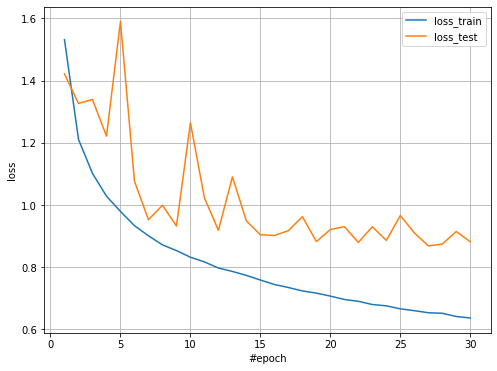

In [60]:
plt.figure(figsize=(8, 6))
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(np.arange(1,31), loss_train_1, label = 'loss_train')
plt.plot(np.arange(1,31), loss_test_1, label = 'loss_test')
plt.legend()
plt.grid(True)
plt.show()

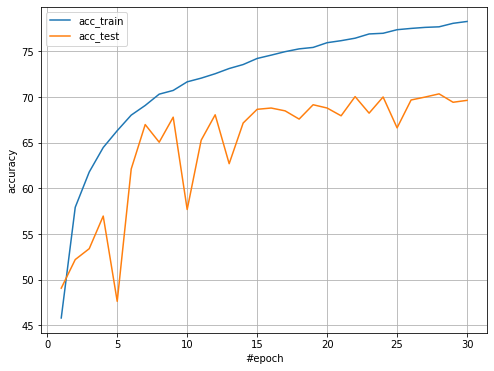

In [61]:
plt.figure(figsize=(8, 6))
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot( np.arange(1,31), accuracy_train_1, label = 'acc_train')
plt.plot( np.arange(1,31), accuracy_test_1, label = 'acc_test')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
dataiter = iter(test_loader)
img, lab = dataiter.next()
pred = model(img)
predict = torch.max(pred.data, 1)[1]
correct = (predict == lab).sum()
accuracy = 100 * correct / float(len(lab))

In [63]:
print("Accuracy: {} %".format(float(accuracy)))

Accuracy: 67.578125 %


# Accuracy показала небольшой результат, давайте попробуем загрузить модель resnet с готовыми весами и обучить отдельные последнии слои, в надежде на более высокие показатели.

In [95]:
model_resnet18 = torchvision.models.resnet18(pretrained=True)
for p in model_resnet18.parameters():
      p.requires_grad_(False)

num_feat = model_resnet18.fc.in_features
#model_resnet18.fc = nn.Linear(num_feat, 50)

model_resnet18.fc = nn.Sequential(
    nn.Linear(num_feat, 250),
    nn.ReLU(),
    nn.Linear(250, 100),
    nn.ReLU(),
    nn.Linear(100, 10),   
    )

for p in model_resnet18.layer4.parameters():
      p.requires_grad_(True)
      
for p in model_resnet18.fc.parameters():
    p.requires_grad_(True)

In [96]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [97]:
torchsummary.summary(model_resnet18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [98]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
#model = TinyNeuralNetwork().to(device)
#model = model_resnet18()
learning_rate = 0.001
optimizer = torch.optim.SGD(model_resnet18.parameters(), lr=learning_rate, momentum=0.9) 
#optimizer = Adam(model.parameters(), lr=1e-3)
error = nn.CrossEntropyLoss() 
#error = nn.NLLLoss()

count = 0

loss_train_1 = []
loss_test_1 = []

accuracy_train_1 = []
accuracy_test_1 = []

for epoch in range(5):
    loss_train_epoch = []
    loss_test_epoch = []
    accuracy_train_epoch = []
    accuracy_test_epoch = []
    
    model_resnet18.train(True)
    for i, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            outputs = model_resnet18(images)
            loss = error(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted1 = torch.max(outputs.data, 1)[1]
            total1 = len(labels)
            correct1 = (predicted1 == labels).sum()
            accuracy1 = 100 * correct1 / float(total1)
            accuracy_train_epoch.append(accuracy1)
            loss_train_epoch.append(loss.item())
            count += 1

    model_resnet18.train(False) 
    with torch.no_grad():
        correct2 = 0
        total2 = 0
        for test_images, labels in test_loader: 

            outputs = model_resnet18(test_images)
            loss_ = error(outputs, labels)
            predicted2 = torch.max(outputs.data, 1)[1]

            total2 += len(labels)
            correct2 += (predicted2 == labels).sum()
            loss_test_epoch.append(loss_.item())

        accuracy2 = 100 * correct2 / float(total2)
        accuracy_test_epoch.append(accuracy2)  
    
    accuracy_train_1.append(np.mean(accuracy_train_epoch))
    accuracy_test_1.append(np.mean(accuracy_test_epoch))
    loss_train_1.append(np.mean(loss_train_epoch))
    loss_test_1.append(np.mean(loss_test_epoch))
    print('Epoch: {}  Loss: {}  Accuracy: {}%'.format(epoch+1, loss_test_1[-1], accuracy2))

Epoch: 1  Loss: 1.3977317363023758  Accuracy: 50.310001373291016%
Epoch: 2  Loss: 1.1585281521081925  Accuracy: 57.959999084472656%
Epoch: 3  Loss: 1.0763208985328674  Accuracy: 61.88999938964844%
Epoch: 4  Loss: 1.028208638727665  Accuracy: 64.47000122070312%
Epoch: 5  Loss: 1.0247209072113037  Accuracy: 64.7300033569336%


In [100]:
dataiter = iter(test_loader)
img, lab = dataiter.next()
pred = model_resnet18(img)
predict = torch.max(pred.data, 1)[1]
correct = (predict == lab).sum()
accuracy = 100 * correct / float(len(lab))

In [101]:
print("Accuracy: {} %".format(float(accuracy)))

Accuracy: 66.015625 %


# Как можно заметить результат не превзошел наши ожидания, могу сделать вывод, что как бы мы не старались из данного датасета получить accuracy более 75% не получится. 